In [1]:
#Version
from qiskit import *
#Amitava Chakraborty 14th Dec 2019

# Quantum Teleportation
It allows us to transfer a quantum state from one qubit to another. 
This might seem fundamentally impossible due to the no-cloning theorem (1982), but it uses entanglement as a resource. 
Using the teleportation protocol, quantum information is destroyed in one place, and an exact copy is recreated in another place. The teleportation protocol was described by <i>Charles Bennett et. al.</i> in March 1993.

## How to Build the circuit for quantum teleportation?
Objective is to teleport the quantum state $\vert\psi\rangle$ from Alice to Bob. <br>
The teleportation protocol is:<br>
1. Alice and Bob create an entangled Bell pair between their two qubits - by using a Hadamard and CX gate.
2. Alice applies a series of operations between the qubit with state $\vert\psi\rangle$ and her half (means her share 1 qubit out of two qubit entangled pair) of the Bell pair.
3. Alice measures both qubits (the one that initially contained $\vert\psi\rangle$ and the other that contained her half of the Bell pair)
4. Alice reports the results to Bob.
5. Depending on what Alice says, Bob applies a couple of gates to his half of the Bell pair - thereby the state $\vert\psi\rangle$ has been teleported to Bob's qubit.

In this version, Bob will apply his gates <b>conditioned on</b> Alice's qubits, instead of the classical outcomes of the measurements that Alice did. There is a subtle difference between these two methods. In the first method (using Alice's qubits after measurement as the controls of Bob's gates) is easy to implement, the second method (using the classical results of Alice's measurement as controls of Bob's gates) allows quantum teleportation <b>over long distances</b>.

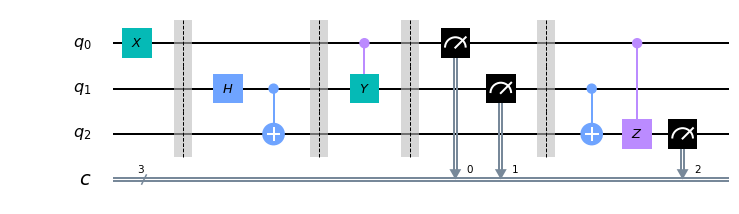

In [7]:
circuit = QuantumCircuit(3,3)
# q0 - State |psi> that we want to teleport
# q1 - Alice's half of the Bell pair
# q2 - Bob's half of the Bell pair, the destination of the teleportation
# barriers are used as visual aids

# Step 0: Create the state to be teleported in qubit 0
circuit.x(0) # qubit 0 is now in state |1> - this is the state that Alice want to teleport
circuit.barrier() 

# Step 1: With qubits 1 and 2 - create an entangled Bell pair between Alice and Bob 
circuit.h(1)
circuit.cx(1,2)
circuit.barrier() 

# Step 2: Alice applies a series of operations (any operations)
# between the state to teleport (qubit 0) and her half of the Bell pair (qubit 1)
circuit.cy(0,1)
#circuit.h(0)
circuit.barrier() 

# Step 3: Alice measures both qubits 0 and 1
circuit.measure([0, 1], [0, 1]) # results stored in classical bits 0 and 1, respectively
circuit.barrier()

# Step 4: Now that Alice has measured the two qubits, their states have collapsed to 0 and 1. 
# Bob can do operations conditioned on these qubits to his half of the Bell pair
# Note that while we're conditioning Bob's operation on the collapsed qubits 0 and 1, we can
# do teleportation over long distances by transmitting the classical information in classical bits 0 and 1
circuit.cx(1, 2)
circuit.cz(0, 2)

# Step 5: Done! Measure Bob's qubit to find out what state it is in
circuit.measure([2], [2])
#As always, let's draw the circuit before simulating to make sure it's doing what we want
%matplotlib inline
circuit.draw(output='mpl')

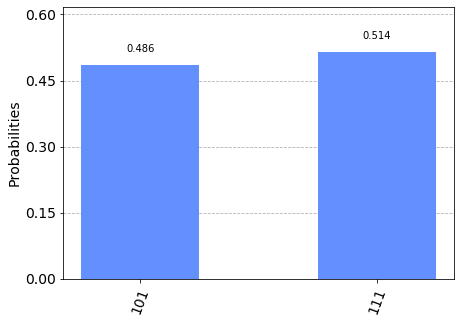

In [8]:
#Running the quantum teleportation circuit
#And finally, let's simulate the circuit on Aer's qasm_simulator
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend=simulator, shots=1024).result()
from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts(circuit))

Now the results above are ordered as $c_2c_1c_0$, with the bottom-most bit being $c_2$, which was the result of measuring the state in qubit 2. As you can see, the result is always $c_2 = 1$ since we teleported the state $\vert1\rangle$ to qubit 2.

In [ ]:
## Method 2 : Using Circuit Building Functions

In [16]:
#We will build the teleportation circuit using subcircuits. 
#This allows us to initialize different instances of the state to be teleported.

#Note the small change in the measurement of qubit 2 
#we are measuring along the Hadamard basis, instead of along the z axis. 
#This is achieved by the use of a Hadamard gate before the measurement.

def create_parameterized_state(theta):
    # Create a state along the x axis on the x-y plane and then rotate it by angle theta around the z-axis
    # theta = 0 => state is exactly along x
    # theta = pi/2 => state is exactly along y
    qc_psi = QuantumCircuit(1, name='psi')
    qc_psi.h(0)
    qc_psi.rz(theta, 0)
    return qc_psi

def create_BellPair():
    qc_Bell = QuantumCircuit(2, name='BellPair')
    qc_Bell.h(0)
    qc_Bell.cx(0,1)
    return qc_Bell

def teleportation_Alice():
    qc_teleportation_Alice = QuantumCircuit(2, name='t_Alice')
    qc_teleportation_Alice.cx(0,1)
    qc_teleportation_Alice.h(0)
    return qc_teleportation_Alice

def measure_Alice():
    qc_measure_Alice = QuantumCircuit(2, 2, name='m_Alice')
    qc_measure_Alice.measure([0,1], [0,1])
    return qc_measure_Alice

def teleportation_Bob():
    qc_teleportation_Bob = QuantumCircuit(3, name='t_Bob')
    qc_teleportation_Bob.cx(1,2)
    qc_teleportation_Bob.cz(0,2)
    return qc_teleportation_Bob

def build_circuit(theta):
    qc = QuantumCircuit(3, 3)
    # Step 0: create the state to teleport
    qc.append(create_parameterized_state(theta).to_instruction(), [0])
    qc.barrier()
    # Step 1: create the Bell pair between Alice and Bob's qubits
    qc.append(create_BellPair().to_instruction(), [1,2])
    qc.barrier()
    # Step 2: Alice applies a series of operations
    qc.append(teleportation_Alice().to_instruction(), [0,1])
    qc.barrier()
    # Step 3: Alice measures her two qubits
    qc.append(measure_Alice().to_instruction(), [0,1], [0,1])
    qc.barrier()
    # Step 4: Bob applies operations to his qubit depending on Alice's measurement outcomes
    qc.append(teleportation_Bob().to_instruction(), [0,1,2])
    qc.barrier()
    # Step 5: Done. Now measure Bob's qubit to be sure that teleportation was successful
    qc.h(2) # note that the Hadamard gate here ensures that we measure in the Hadamard basis instead of z basis
    qc.measure([0,1,2], [0,1,2])
    return qc

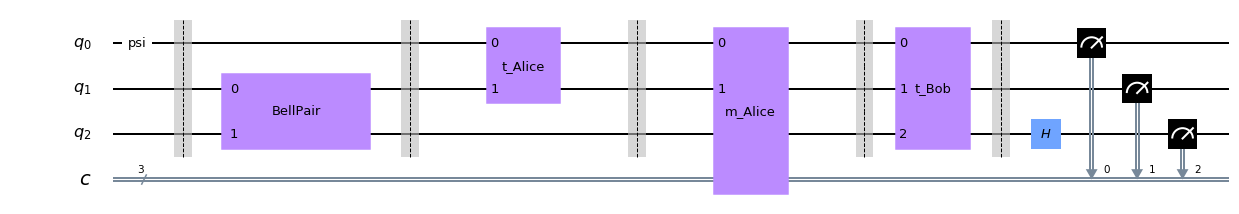

In [17]:
circuit = build_circuit(0.01)
circuit.draw(output='mpl')

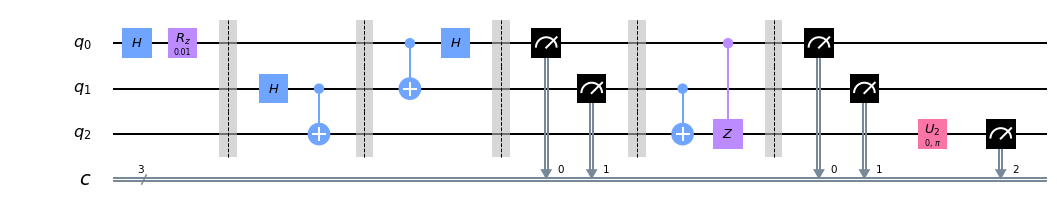

In [18]:
#In order to expand the circuit above, we can write
circuit.decompose().draw(output='mpl')

In [19]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend=simulator, shots=1024).result()
counts = result.get_counts(circuit)
print(counts)
num_c2_zero = sum(counts[c2c1c0] for c2c1c0 in counts if c2c1c0[0] == '0')

{'010': 254, '001': 237, '000': 267, '011': 266}


In [3]:
#Now, let's make a loop that iterates over several initial angles $\theta$
import numpy as np
thetas = np.arange(0, 4*np.pi, np.pi/16)

simulator = Aer.get_backend('qasm_simulator')

percent_ones = []

for theta in thetas:
    circuit = build_circuit(theta)
    result = execute(circuit, backend=simulator, shots=1024).result()
    counts = result.get_counts(circuit)
    num_c2_ones = sum(counts[c2c1c0] for c2c1c0 in counts if c2c1c0[0] == '1')
    percent_ones.append(num_c2_ones*100./1024)
    
import matplotlib.pyplot as plotter
plotter.plot(thetas, percent_ones)
plotter.xlabel('Initial angle, theta (radians)')
plotter.ylabel('Percentage of 1 counts')
plotter.show()

NameError: name 'build_circuit' is not defined

In [4]:
#As you can see, the measurement results show a sinusoidal periodicity. Since we are measuring along the Hadamard basis, and we begin with a state that is entirely along the $x$-axis, we are able to follow the change in phase

#Running the teleportation circuit on real quantum hardware
#As before, we will now create circuits for various values of $\theta$, and then send all the circuits to the IBMQ backend called ibmq_16_melbourne. We will map the qubits 0, 1 and 2 to the physical qubits 6, 8 and 7, respectively.

# build circuits
thetas = np.arange(0, 4*np.pi, np.pi/16)

circuits = []
for theta in thetas:
    circuit = build_circuit(theta)
    circuits.append(circuit)

# load account
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
qcomp = provider.get_backend('ibmq_16_melbourne')

# run the job on the backend qcomp
job = execute(circuits, backend=qcomp, shots=512, initial_layout=[6,8,7])
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

NameError: name 'build_circuit' is not defined

In [22]:
simresult = execute(circuits, backend=simulator, shots=512).result()

In [24]:
job.error_message()

'Qubit measurement is followed by instructions. Error code: 7006.'

In [23]:
result = job.result()

percent_ones = []
for circuit in circuits:
    thiscircuit_counts = result.get_counts(circuit)
    num_c2_ones = sum(thiscircuit_counts[c2c1c0] for c2c1c0 in thiscircuit_counts if c2c1c0[0] == '1')
    percent_ones.append(num_c2_ones*100./512)
    
percent_ones_sim = []
for circuit in circuits:
    thiscircuit_counts = simresult.get_counts(circuit)
    num_c2_ones = sum(thiscircuit_counts[c2c1c0] for c2c1c0 in thiscircuit_counts if c2c1c0[0] == '1')
    percent_ones_sim.append(num_c2_ones*100./512)
    
plotter.plot(thetas, percent_ones, 'r.', label='Real device')
plotter.plot(thetas, percent_ones_sim, 'k', label='Simulator')
plotter.xlabel('Initial angle, theta (radians)')
plotter.ylabel('Percentage of 1 counts')
plotter.legend()
plotter.show()

IBMQJobFailureError: 'Unable to retrieve result for job 5e99867bc73c1d0018b493e4. Job has failed. Use job.error_message() to get more details.'

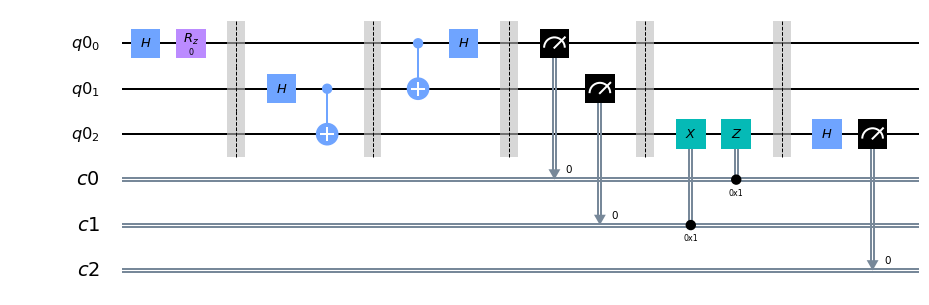

In [17]:
#Quantum teleportation over long distances
#In the above work, Bob applied quantum gates to his half of the Bell pair based on Alice's qubits. This is a simplified version of the teleportation algorithm. The most useful aspect of the algorithm becomes apparent when, instead of using Alice's qubits for controlling Bob's gates, we use the classical outcomes of the measurement of Alice's qubits for controlling Bob's gates.

#In Qiskit, this is achieved using c_if as shown below. This feature of conditioning a quantum gate on a classical register is currently unavailable on the real quantum hardware, and circuits containing this feature can only be executed on the simulators.
thetas = np.arange(0, 4*np.pi, np.pi/16)
circuits_classicalcontrol = []
for theta in thetas:
    cr1 = ClassicalRegister(1)
    cr2 = ClassicalRegister(1)
    cr3 = ClassicalRegister(1)
    qr = QuantumRegister(3)
    circuit = QuantumCircuit(qr, cr1, cr2, cr3)

    # Step 0: Create the state to be teleported in qubit 0
    circuit.h(0)
    circuit.rz(theta, 0)
    circuit.barrier()

    # Step 1: create an entangled Bell pair between Alice and Bob (qubits 1 and 2)
    circuit.h(1)
    circuit.cx(1,2)
    circuit.barrier()

    # Step 2: Alice applies a series of operations 
    # between the state to teleport (qubit 0) and her half of the Bell pair (qubit 1)
    circuit.cx(0,1)
    circuit.h(0)
    circuit.barrier()

    # Step 3: Alice measures both qubits 0 and 1
    circuit.measure([0, 1], [0, 1]) # results stored in classical bits 0 and 1, respectively
    circuit.barrier()

    # Step 4: Now that Alice has measured the two qubits, their states have collapsed to 0 and 1. 
    # Use the classical bits from Alice's measurements to do operations on Bob's half of the Bell pair
    circuit.x(2).c_if(cr2, 1)
    circuit.z(2).c_if(cr1, 1)
    circuit.barrier()
    # Step 5: Done! Measure Bob's qubit in the Hadamard basis to find out what state it is in
    circuit.h(2)
    circuit.measure([2], [2])
    
    circuits_classicalcontrol.append(circuit)
    
circuits_classicalcontrol[0].draw()

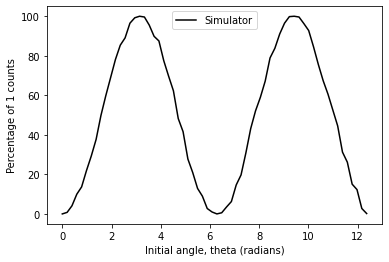

In [18]:
simulator = Aer.get_backend('qasm_simulator')
simresult_classicalcontrol = execute(circuits_classicalcontrol, backend=simulator, shots=512).result()

percent_ones_sim = []
for ii in range(len((circuits))):
    thiscircuit_counts = simresult_classicalcontrol.get_counts(ii)
    num_c2_ones = sum(thiscircuit_counts[c2c1c0] for c2c1c0 in thiscircuit_counts if c2c1c0[0] == '1')
    percent_ones_sim.append(num_c2_ones*100./512)
    
plotter.plot(thetas, percent_ones_sim, 'k', label='Simulator')
plotter.xlabel('Initial angle, theta (radians)')
plotter.ylabel('Percentage of 1 counts')
plotter.legend()
plotter.show()

In [19]:
#Notice that the above results were achieved without any quantum gates between qubits 1 and 2 after they were entangled. In fact, the two qubits can be physically separated. As long as the classical information from the two measurements of Alice's qubits can be transferred quickly enough, teleportation can be achieved over long distances.

#References
#Journal Papers
#Charles Bennett et al., Teleporting an Unknown Quantum State via Dual Classical and Einstein-Podolsky-Rosen Channels. Phys. Rev. Lett. 70, 1895 (1993). https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.70.1895
#W. K. Wootters & W. H. Zurek, A single quantum cannot be cloned. Nature 299, 802 (1982). https://www.nature.com/articles/299802a0
#Tutorials
#For detailed information about Qiskit, check out the tutorials in the Github repository:

#For a pedagogical presentation of the mathematics behind the quantum teleportation circuit, check out our open-source Learn Quantum Computation using Qiskit textbook:
#https://community.qiskit.org/textbook/

# Another Example

In [1]:
'''
    Quantum Teleportation

    Task. Alice would like to send Bob a qubit that is in some unknown state.

'''
from qiskit import IBMQ, BasicAer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

qr = QuantumRegister(3)  # Initialize qubits
cr0 = ClassicalRegister(1)
cr1 = ClassicalRegister(1)
cr2 = ClassicalRegister(1)
circuit = QuantumCircuit(qr, cr0, cr1, cr2)

# Prepare the initial state which we want to transfer
circuit.x(qr[0])

# Prepare the Bell pair
circuit.h(qr[1])
circuit.cx(qr[1], qr[2])

circuit.barrier()

# Measure in the Bell basis
circuit.cx(qr[0], qr[1])
circuit.h(qr[0])
circuit.measure(qr[0], cr0[0])
circuit.measure(qr[1], cr1[0])

circuit.barrier()

# Apply a correction
circuit.z(qr[2]).c_if(cr0, 1)
circuit.x(qr[2]).c_if(cr1, 1)
circuit.measure(qr[2], cr2[0])

# Run our circuit with local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
print(answer)

{'1 0 0': 261, '1 1 1': 266, '1 0 1': 257, '1 1 0': 240}
